<a href="https://colab.research.google.com/github/jesuinovieira/backpropaganda/blob/main/CNN_MNIST_CatastrophicForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Cell 1: Imports and Configuration
"""
MNIST CNN - Catastrophic Forgetting Experiment
==============================================

This notebook demonstrates catastrophic forgetting by training a CNN on
5 sequential tasks with digit pairs: (0,1), (2,3), (4,5), (6,7), (8,9)

Author: [Your Name]
Course: NeuroAI
Experiment: Sequential Learning with Catastrophic Forgetting
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Configuration parameters
LATENT_DIM = 84
NUM_CLASSES = 10
BATCH_SIZE = 128          # Increased for better GPU utilization
LEARNING_RATE = 0.001
EPOCHS_PER_TASK = 10      # Epochs to train on each task

# Define the 5 sequential tasks (digit pairs)
TASKS = [
    (0, 1),  # Task 1: digits 0 and 1
    (2, 3),  # Task 2: digits 2 and 3
    (4, 5),  # Task 3: digits 4 and 5
    (6, 7),  # Task 4: digits 6 and 7
    (8, 9)   # Task 5: digits 8 and 9
]

print(f"Catastrophic Forgetting Experiment Setup:")
print(f"Number of tasks: {len(TASKS)}")
print(f"Tasks: {TASKS}")
print(f"Epochs per task: {EPOCHS_PER_TASK}")
print("Configuration loaded successfully!")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Catastrophic Forgetting Experiment Setup:
Number of tasks: 5
Tasks: [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
Epochs per task: 10
Configuration loaded successfully!


In [2]:
#@title Cell 2: CNN Model Definition
class ConvNeuralNet(nn.Module):
    """
    Convolutional Neural Network for MNIST digit classification.
    Same architecture as before, designed to learn all 10 digit classes.
    """

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNeuralNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, LATENT_DIM)
        self.fc3 = nn.Linear(LATENT_DIM, num_classes)

    def forward(self, x):
        # Conv layers with ReLU and MaxPool
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # Flatten and fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

print("CNN model defined successfully!")


CNN model defined successfully!


In [3]:
#@title Cell 3: Data Loading and Task Creation Functions
def load_mnist_data():
    """Load the complete MNIST dataset."""
    mnist_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=mnist_transform, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=mnist_transform, download=True
    )

    return train_dataset, test_dataset

def create_task_datasets(dataset, task_digits):
    """
    Create a dataset containing only specific digit classes.

    Args:
        dataset: Full MNIST dataset
        task_digits: Tuple of digit classes (e.g., (0, 1))

    Returns:
        Subset dataset containing only the specified digits
    """
    indices = []
    for i, (_, label) in enumerate(dataset):
        if label in task_digits:
            indices.append(i)

    return Subset(dataset, indices)

def create_all_task_dataloaders(train_dataset, test_dataset):
    """Create data loaders for all tasks."""
    task_loaders = {
        'train': [],
        'test': []
    }

    for i, task_digits in enumerate(TASKS):
        # Create training dataset for this task
        train_task = create_task_datasets(train_dataset, task_digits)
        train_loader = DataLoader(
            train_task,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )

        # Create test dataset for this task
        test_task = create_task_datasets(test_dataset, task_digits)
        test_loader = DataLoader(
            test_task,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        task_loaders['train'].append(train_loader)
        task_loaders['test'].append(test_loader)

        print(f"Task {i+1} {task_digits}: Train samples = {len(train_task)}, Test samples = {len(test_task)}")

    return task_loaders

print("Data loading functions defined!")

Data loading functions defined!


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


Full Dataset Information:
Total training samples: 60,000
Total test samples: 10,000

Task 1 (0, 1): Train samples = 12665, Test samples = 2115
Task 2 (2, 3): Train samples = 12089, Test samples = 2042
Task 3 (4, 5): Train samples = 11263, Test samples = 1874
Task 4 (6, 7): Train samples = 12183, Test samples = 1986
Task 5 (8, 9): Train samples = 11800, Test samples = 1983

Created 5 tasks successfully!


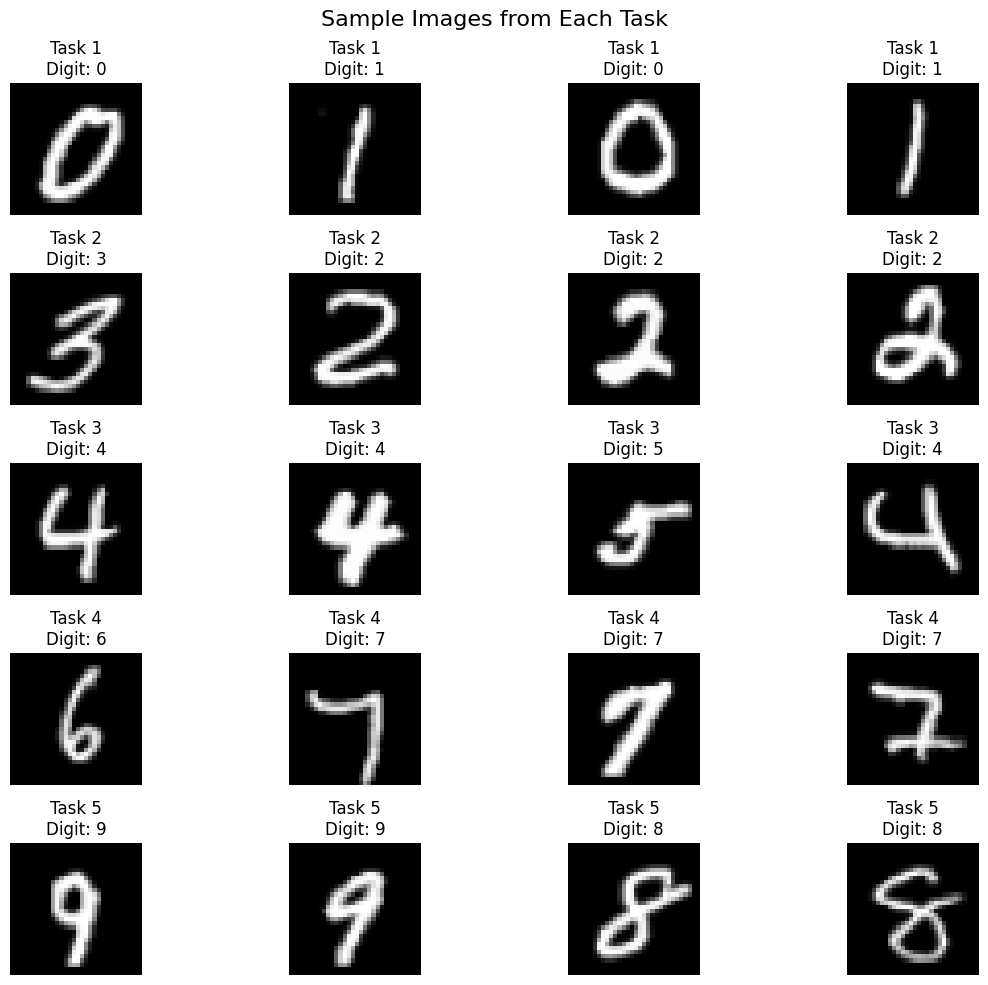

In [4]:
#@title Cell 4: Load Data and Create Task Splits
# Load the complete MNIST dataset
train_dataset, test_dataset = load_mnist_data()

print("Full Dataset Information:")
print(f"Total training samples: {len(train_dataset):,}")
print(f"Total test samples: {len(test_dataset):,}")
print()

# Create task-specific data loaders
task_loaders = create_all_task_dataloaders(train_dataset, test_dataset)

print(f"\nCreated {len(TASKS)} tasks successfully!")

# Visualize samples from each task
def visualize_task_samples():
    """Visualize sample images from each task."""
    fig, axes = plt.subplots(len(TASKS), 4, figsize=(12, 10))

    for task_idx, task_digits in enumerate(TASKS):
        # Get samples from this task
        data_iter = iter(task_loaders['train'][task_idx])
        images, labels = next(data_iter)

        # Show 4 samples from this task
        for sample_idx in range(4):
            if sample_idx < len(images):
                img = images[sample_idx].squeeze()
                img = img * 0.3081 + 0.1307  # Denormalize
                img = torch.clamp(img, 0, 1)

                axes[task_idx, sample_idx].imshow(img.numpy(), cmap='gray')
                axes[task_idx, sample_idx].set_title(f'Task {task_idx+1}\nDigit: {labels[sample_idx].item()}')
                axes[task_idx, sample_idx].axis('off')

    plt.suptitle('Sample Images from Each Task', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_task_samples()

In [5]:
#@title Cell 5: Training and Evaluation Functions
def train_on_task_with_eval(model, train_loader, all_test_loaders, criterion, optimizer, task_num, epochs=EPOCHS_PER_TASK):
    """
    Train the model on a specific task while evaluating on all tasks at each epoch.

    Returns:
        dict: Contains training losses and epoch-by-epoch performance on all tasks
    """
    model.train()

    # Track training losses
    task_losses = []

    # Track performance on all tasks at each epoch
    epoch_performances = []  # List of lists: [epoch_0_all_tasks, epoch_1_all_tasks, ...]

    print(f"\nTraining on Task {task_num} for {epochs} epochs...")
    print("-" * 70)

    for epoch in range(epochs):
        # === TRAINING PHASE ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data, targets in train_loader:
            # Move data to GPU
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        task_losses.append(epoch_loss)

        # === EVALUATION PHASE ===
        # Evaluate on all tasks (including previous ones and current one)
        current_epoch_performance = []
        for eval_task_idx in range(len(all_test_loaders)):
            if eval_task_idx < len(all_test_loaders):  # Only evaluate on tasks we've seen
                acc = evaluate_on_task(model, all_test_loaders[eval_task_idx], eval_task_idx + 1)
                current_epoch_performance.append(acc)
            else:
                current_epoch_performance.append(0.0)  # Haven't seen this task yet

        epoch_performances.append(current_epoch_performance)

        # Print progress
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f'  Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
            # Show performance on previous tasks to see forgetting in real-time
            if task_num > 1:
                prev_tasks_acc = [current_epoch_performance[i] for i in range(task_num-1)]
                avg_prev_acc = np.mean(prev_tasks_acc) if prev_tasks_acc else 0
                print(f'    Avg performance on previous tasks: {avg_prev_acc:.2f}%')

    return {
        'losses': task_losses,
        'epoch_performances': epoch_performances
    }

def train_on_task(model, train_loader, criterion, optimizer, task_num, epochs=EPOCHS_PER_TASK):
    """Simplified training function (kept for compatibility)."""
    model.train()
    task_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        task_losses.append(epoch_loss)

    return task_losses

def evaluate_on_task(model, test_loader, task_num):
    """Evaluate the model on a specific task."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

def evaluate_on_all_tasks(model, task_loaders):
    """Evaluate the model on all tasks."""
    accuracies = []
    for task_idx in range(len(TASKS)):
        acc = evaluate_on_task(model, task_loaders['test'][task_idx], task_idx + 1)
        accuracies.append(acc)
    return accuracies

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


In [6]:
#@title Cell 6: Run Catastrophic Forgetting Experiment with Epoch-by-Epoch Tracking
# Initialize model, loss, and optimizer
model = ConvNeuralNet(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Model initialized and moved to {device}")
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Enhanced tracking for epoch-by-epoch analysis
detailed_performance = []    # Store epoch-by-epoch performance for each task
training_losses = []         # Training losses for each task
performance_matrix = []      # Final performance after each task (for compatibility)

print(f"\nStarting Detailed Catastrophic Forgetting Experiment")
print("=" * 70)

# Train on each task sequentially with detailed tracking
for current_task in range(len(TASKS)):
    task_digits = TASKS[current_task]
    task_num = current_task + 1

    print(f"\n🔄 PHASE {task_num}: Training on digits {task_digits}")

    # Train on current task with epoch-by-epoch evaluation
    training_results = train_on_task_with_eval(
        model,
        task_loaders['train'][current_task],
        task_loaders['test'],  # Pass all test loaders
        criterion,
        optimizer,
        task_num,
        EPOCHS_PER_TASK
    )

    # Store results
    training_losses.append(training_results['losses'])
    detailed_performance.append(training_results['epoch_performances'])

    # Final evaluation after this task (for compatibility with previous analysis)
    final_performance = evaluate_on_all_tasks(model, task_loaders)
    performance_matrix.append(final_performance)

    # Display final results for this training phase
    print(f"\n📊 Final performance after Task {task_num}:")
    for eval_task in range(task_num):  # Only show tasks we've trained on
        task_digits_eval = TASKS[eval_task]
        acc = final_performance[eval_task]
        status = "🔥" if eval_task == current_task else ("✅" if acc > 80 else "❌")
        print(f"  Task {eval_task+1} {task_digits_eval}: {acc:.2f}% {status}")

print(f"\n🎯 Detailed experiment completed!")

# Convert to numpy arrays for easier analysis
performance_matrix = np.array(performance_matrix)
detailed_performance = np.array(detailed_performance)  # Shape: [task, epoch, evaluated_task]

print(f"Performance tracking shape: {detailed_performance.shape}")
print(f"(Tasks trained, Epochs per task, Tasks evaluated)")


Model initialized and moved to cuda
Total parameters: 61,706

Starting Detailed Catastrophic Forgetting Experiment

🔄 PHASE 1: Training on digits (0, 1)

Training on Task 1 for 10 epochs...
----------------------------------------------------------------------
  Epoch [1/10] Loss: 0.2164, Train Acc: 94.39%
  Epoch [2/10] Loss: 0.0088, Train Acc: 99.73%
  Epoch [4/10] Loss: 0.0031, Train Acc: 99.92%
  Epoch [6/10] Loss: 0.0019, Train Acc: 99.92%
  Epoch [8/10] Loss: 0.0012, Train Acc: 99.98%
  Epoch [10/10] Loss: 0.0013, Train Acc: 99.95%

📊 Final performance after Task 1:
  Task 1 (0, 1): 99.91% 🔥

🔄 PHASE 2: Training on digits (2, 3)

Training on Task 2 for 10 epochs...
----------------------------------------------------------------------
  Epoch [1/10] Loss: 1.0445, Train Acc: 57.46%
    Avg performance on previous tasks: 0.00%
  Epoch [2/10] Loss: 0.1859, Train Acc: 93.25%
    Avg performance on previous tasks: 0.00%
  Epoch [4/10] Loss: 0.0368, Train Acc: 98.65%
    Avg performanc

In [8]:
#@title Cell 7: Detailed Analysis of Epoch-by-Epoch Forgetting
def analyze_detailed_forgetting():
    """Analyze catastrophic forgetting at the epoch level."""
    print("📈 DETAILED CATASTROPHIC FORGETTING ANALYSIS")
    print("=" * 60)

    # Calculate when catastrophic forgetting starts for each task
    forgetting_onsets = []

    for task_idx in range(len(TASKS) - 1):  # Exclude last task
        task_digits = TASKS[task_idx]

        # Find when this task's performance starts to drop significantly
        # Look at performance during subsequent task training
        if task_idx < detailed_performance.shape[0] - 1:
            # Performance on task_idx during training of subsequent tasks
            subsequent_performance = []

            for later_task in range(task_idx + 1, len(TASKS)):
                if later_task < detailed_performance.shape[0]:
                    # Performance on task_idx during training of later_task
                    perf_during_later = detailed_performance[later_task, :, task_idx]
                    subsequent_performance.extend(perf_during_later)

            if subsequent_performance:
                # Find when performance drops below 50% of original
                original_perf = detailed_performance[task_idx, -1, task_idx]  # Performance after training
                threshold = original_perf * 0.5

                forgetting_epoch = None
                for i, perf in enumerate(subsequent_performance):
                    if perf < threshold:
                        forgetting_epoch = i
                        break

                forgetting_onsets.append(forgetting_epoch)
                print(f"Task {task_idx+1} {task_digits}:")
                print(f"  Original performance: {original_perf:.2f}%")
                print(f"  Forgetting threshold (50%): {threshold:.2f}%")
                if forgetting_epoch is not None:
                    print(f"  Forgetting onset: After {forgetting_epoch} epochs of subsequent training")
                else:
                    print(f"  Forgetting onset: Performance never dropped below threshold")
                print()

    return forgetting_onsets

forgetting_onsets = analyze_detailed_forgetting()

📈 DETAILED CATASTROPHIC FORGETTING ANALYSIS
Task 1 (0, 1):
  Original performance: 99.91%
  Forgetting threshold (50%): 49.95%
  Forgetting onset: After 0 epochs of subsequent training

Task 2 (2, 3):
  Original performance: 99.66%
  Forgetting threshold (50%): 49.83%
  Forgetting onset: After 0 epochs of subsequent training

Task 3 (4, 5):
  Original performance: 99.68%
  Forgetting threshold (50%): 49.84%
  Forgetting onset: After 0 epochs of subsequent training

Task 4 (6, 7):
  Original performance: 99.80%
  Forgetting threshold (50%): 49.90%
  Forgetting onset: After 0 epochs of subsequent training



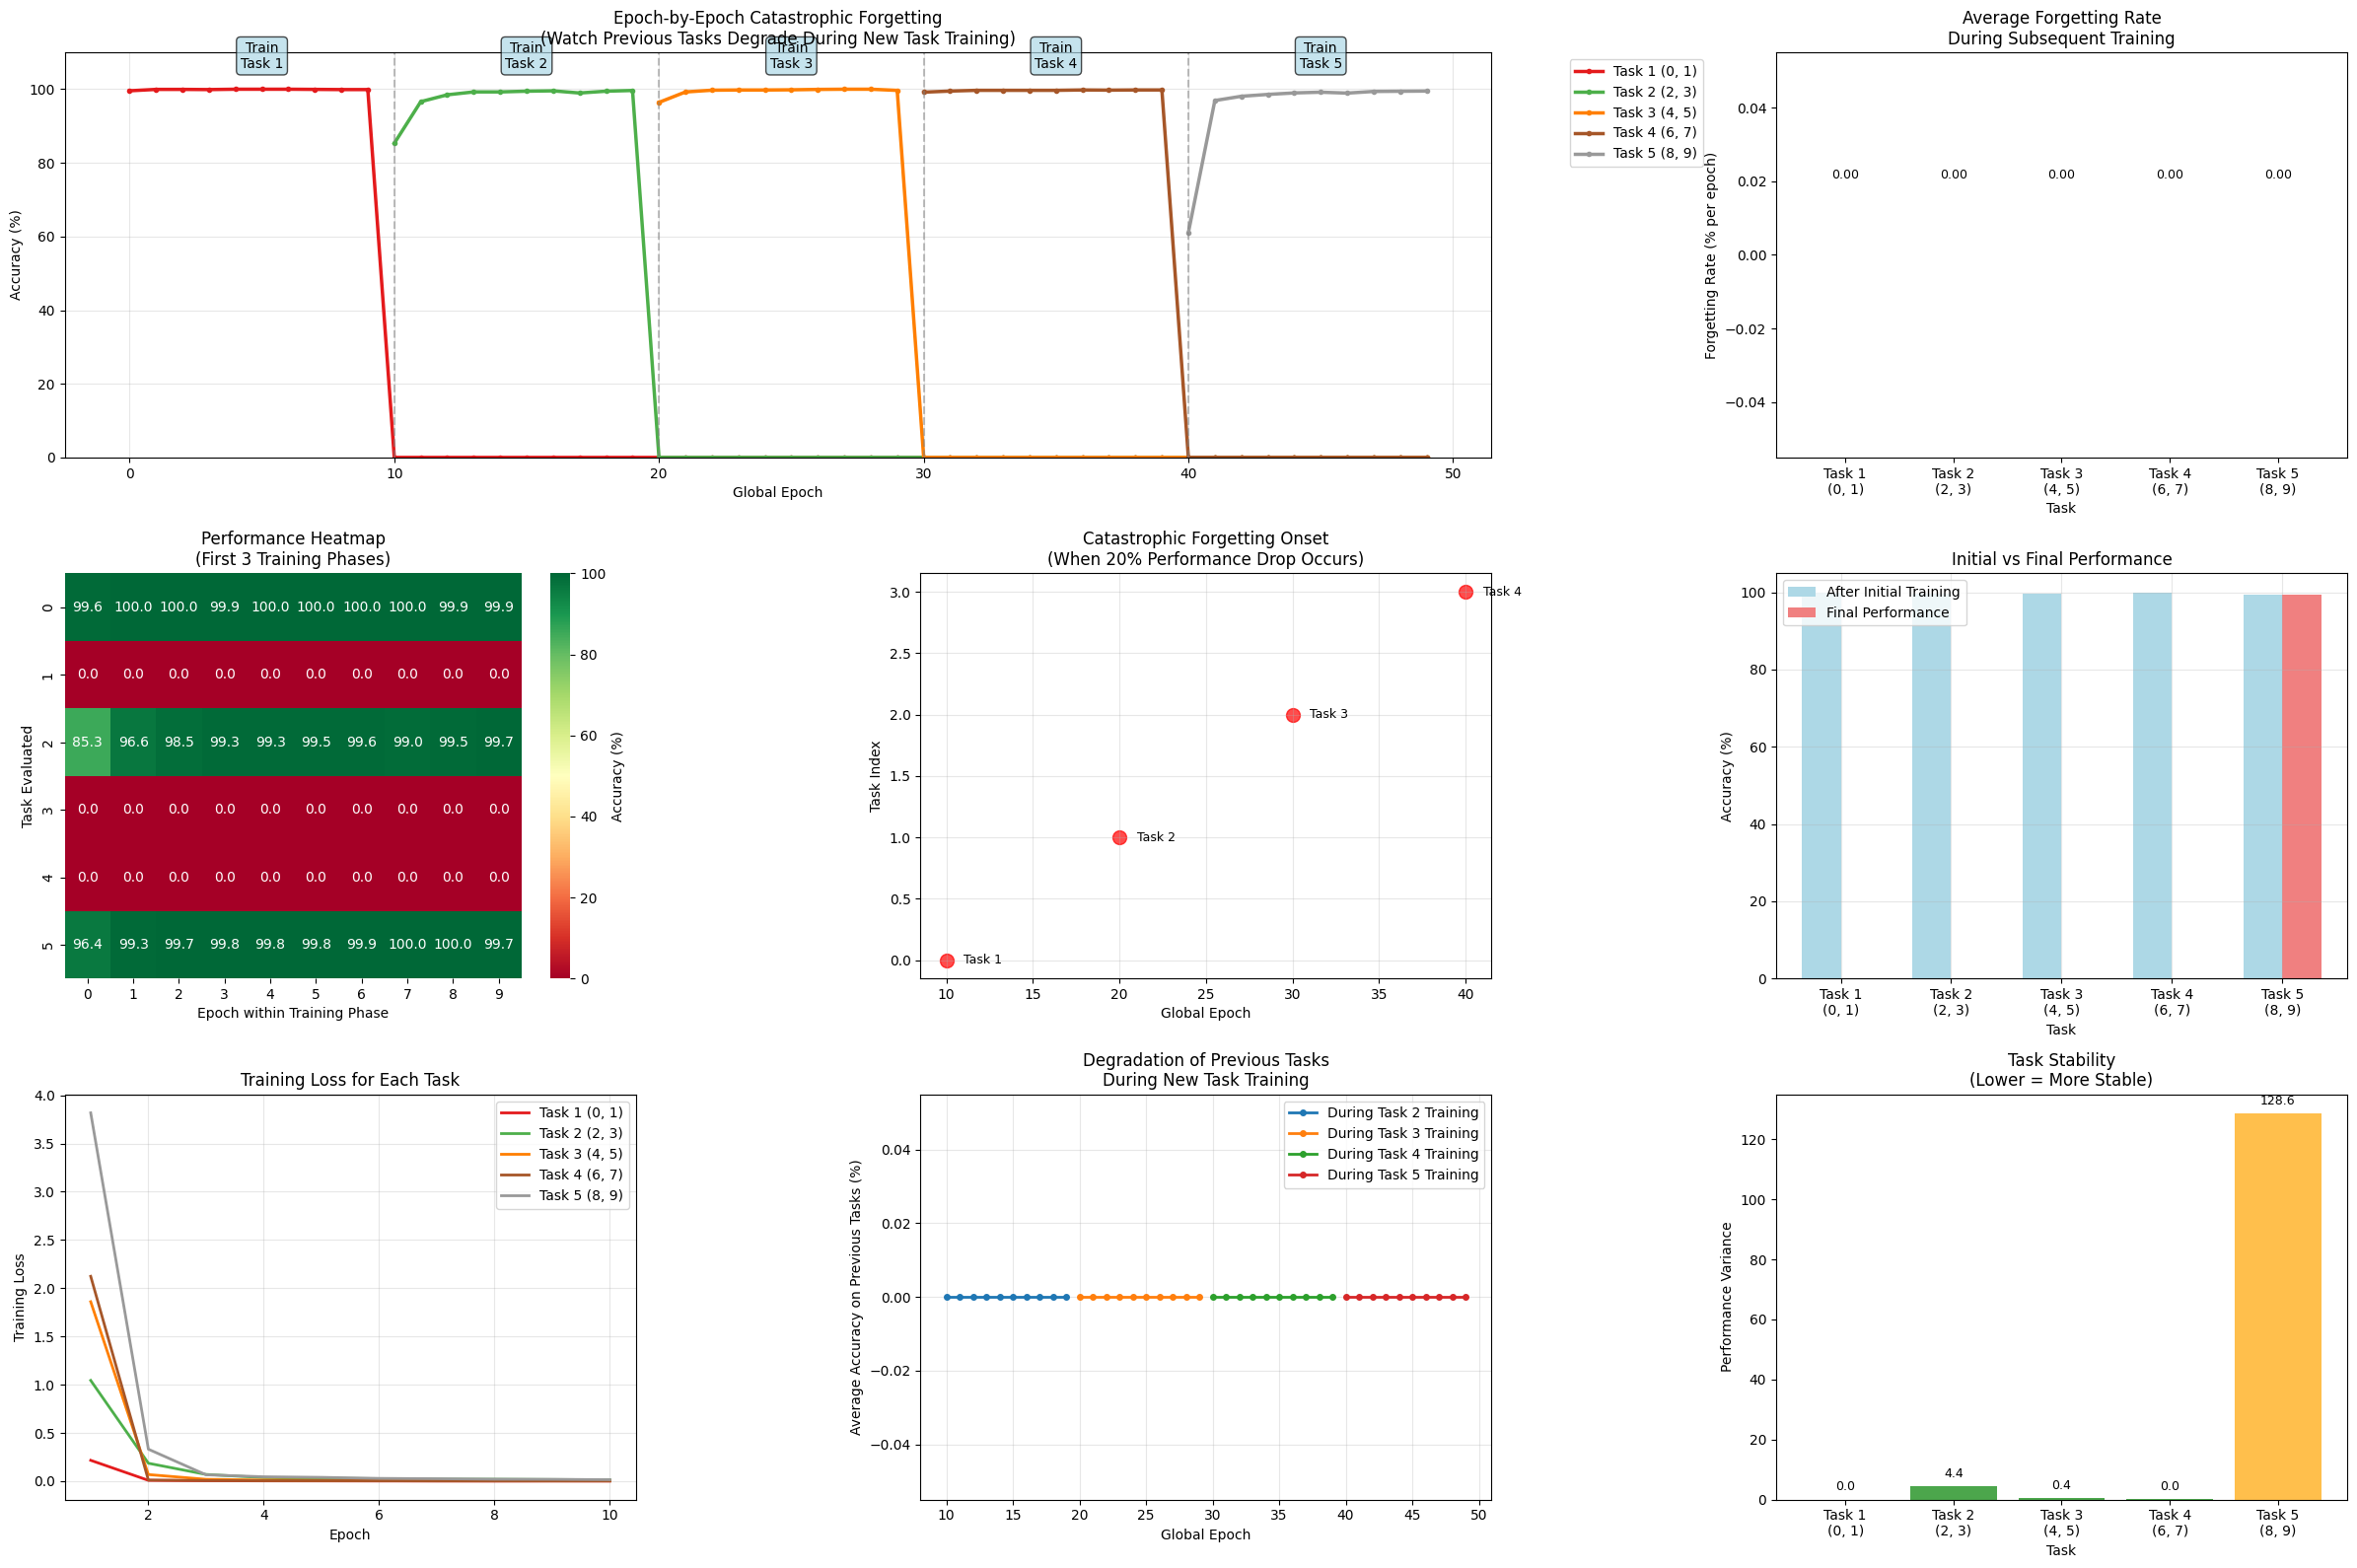

<Figure size 640x480 with 0 Axes>

In [21]:
# Cell 8: Create Enhanced Epoch-by-Epoch Visualizations
def plot_detailed_catastrophic_forgetting():
    """Create detailed visualizations showing epoch-by-epoch catastrophic forgetting."""

    fig = plt.figure(figsize=(24, 16))

    # 1. Epoch-by-Epoch Performance Tracking (Main Plot)
    plt.subplot(3, 3, (1, 2))  # Span 2 columns for this important plot

    colors = plt.cm.Set1(np.linspace(0, 1, len(TASKS)))

    # Create a continuous epoch axis across all tasks
    total_epochs = 0
    epoch_ranges = []

    for task_idx in range(len(TASKS)):
        start_epoch = total_epochs
        end_epoch = total_epochs + EPOCHS_PER_TASK
        epoch_ranges.append((start_epoch, end_epoch))
        total_epochs = end_epoch

    # Plot performance for each task across all training phases
    for task_idx in range(len(TASKS)):
        task_performance_timeline = []
        epoch_timeline = []

        # Collect performance data for this task across all training phases
        for training_phase in range(len(TASKS)):
            if training_phase >= task_idx:  # Only after this task has been trained
                phase_start, phase_end = epoch_ranges[training_phase]

                if training_phase < detailed_performance.shape[0]:
                    # Get performance during this training phase
                    phase_performance = detailed_performance[training_phase, :, task_idx]
                    phase_epochs = np.arange(phase_start, phase_end)

                    task_performance_timeline.extend(phase_performance)
                    epoch_timeline.extend(phase_epochs)

        if task_performance_timeline:
            plt.plot(epoch_timeline, task_performance_timeline,
                    color=colors[task_idx], linewidth=2.5,
                    label=f'Task {task_idx+1} {TASKS[task_idx]}', marker='o', markersize=3)

    # Add vertical lines to separate training phases
    for phase_end in range(EPOCHS_PER_TASK, total_epochs, EPOCHS_PER_TASK):
        plt.axvline(x=phase_end, color='gray', linestyle='--', alpha=0.5)

    # Add phase labels
    for task_idx, (start, end) in enumerate(epoch_ranges):
        mid_point = (start + end) / 2
        plt.text(mid_point, 105, f'Train\nTask {task_idx+1}',
                ha='center', va='bottom', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

    plt.xlabel('Global Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Epoch-by-Epoch Catastrophic Forgetting\n(Watch Previous Tasks Degrade During New Task Training)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 110)

    # 2. Forgetting Rate Analysis
    plt.subplot(3, 3, 3)

    # Calculate forgetting rate (slope) for each task during subsequent training
    forgetting_rates = []
    for task_idx in range(len(TASKS) - 1):
        # Look at performance decline during ALL subsequent training
        decline_data = []

        for later_task in range(task_idx + 1, min(len(TASKS), detailed_performance.shape[0])):
            task_perf = detailed_performance[later_task, :, task_idx]
            if len(task_perf) > 1:
                # Calculate slope (rate of decline)
                epochs = np.arange(len(task_perf))
                slope = np.polyfit(epochs, task_perf, 1)[0]  # Linear fit slope
                decline_data.append(slope)

        avg_forgetting_rate = np.mean(decline_data) if decline_data else 0
        forgetting_rates.append(abs(avg_forgetting_rate))  # Take absolute value

    forgetting_rates.append(0)  # Last task can't be forgotten

    bars = plt.bar(range(len(TASKS)), forgetting_rates,
                   color=['red' if rate > 1 else 'orange' if rate > 0.5 else 'green' for rate in forgetting_rates],
                   alpha=0.7)
    plt.xlabel('Task')
    plt.ylabel('Forgetting Rate (% per epoch)')
    plt.title('Average Forgetting Rate\nDuring Subsequent Training')
    plt.xticks(range(len(TASKS)), [f'Task {i+1}\n{TASKS[i]}' for i in range(len(TASKS))])

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{forgetting_rates[i]:.2f}', ha='center', va='bottom', fontsize=9)

    # 3. Performance Heatmap by Epoch
    plt.subplot(3, 3, 4)

    # Create epoch-level heatmap
    heatmap_data = []
    for task_idx in range(min(3, len(TASKS))):  # Show first 3 tasks for clarity
        if task_idx < detailed_performance.shape[0]:
            task_data = detailed_performance[task_idx, :, :task_idx+1]  # Only tasks seen so far
            heatmap_data.append(task_data)

    if heatmap_data:
        # Combine data from different training phases
        combined_data = np.hstack(heatmap_data) if len(heatmap_data) > 1 else heatmap_data[0]

        sns.heatmap(combined_data.T, annot=True, fmt='.1f', cmap='RdYlGn',
                   cbar_kws={'label': 'Accuracy (%)'})
        plt.title('Performance Heatmap\n(First 3 Training Phases)')
        plt.xlabel('Epoch within Training Phase')
        plt.ylabel('Task Evaluated')

    # 5. Catastrophic Forgetting Timeline
    plt.subplot(3, 3, 5)

    # Show when each task starts to be forgotten
    forgetting_timeline = []
    task_labels = []

    for task_idx in range(len(TASKS) - 1):
        # Find first epoch where performance drops significantly
        original_perf = detailed_performance[task_idx, -1, task_idx] if task_idx < detailed_performance.shape[0] else 0
        threshold = original_perf * 0.8  # 20% drop threshold

        forgetting_epoch = None
        global_epoch_counter = (task_idx + 1) * EPOCHS_PER_TASK  # Start after this task's training

        for later_task in range(task_idx + 1, min(len(TASKS), detailed_performance.shape[0])):
            task_perf = detailed_performance[later_task, :, task_idx]
            for epoch_in_phase, perf in enumerate(task_perf):
                if perf < threshold:
                    forgetting_epoch = global_epoch_counter + epoch_in_phase
                    break
            if forgetting_epoch:
                break
            global_epoch_counter += EPOCHS_PER_TASK

        if forgetting_epoch:
            forgetting_timeline.append(forgetting_epoch)
            task_labels.append(f'Task {task_idx+1}')

    if forgetting_timeline:
        plt.scatter(forgetting_timeline, range(len(forgetting_timeline)),
                   s=100, c='red', alpha=0.7)
        for i, (epoch, label) in enumerate(zip(forgetting_timeline, task_labels)):
            plt.text(epoch + 1, i, label, va='center', fontsize=9)

        plt.xlabel('Global Epoch')
        plt.ylabel('Task Index')
        plt.title('Catastrophic Forgetting Onset\n(When 20% Performance Drop Occurs)')
        plt.grid(True, alpha=0.3)

    # 6. Final vs Initial Performance
    plt.subplot(3, 3, 6)
    initial_performance = [detailed_performance[i, -1, i] if i < detailed_performance.shape[0] else 0
                          for i in range(len(TASKS))]
    final_performance = performance_matrix[-1, :] if len(performance_matrix) > 0 else [0] * len(TASKS)

    x = np.arange(len(TASKS))
    width = 0.35

    plt.bar(x - width/2, initial_performance, width, label='After Initial Training', color='lightblue')
    plt.bar(x + width/2, final_performance, width, label='Final Performance', color='lightcoral')

    plt.xlabel('Task')
    plt.ylabel('Accuracy (%)')
    plt.title('Initial vs Final Performance')
    plt.xticks(x, [f'Task {i+1}\n{TASKS[i]}' for i in range(len(TASKS))])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 7. Training Loss Curves
    plt.subplot(3, 3, 7)
    colors = plt.cm.Set1(np.linspace(0, 1, len(TASKS)))
    for task_idx, (task_losses, color) in enumerate(zip(training_losses, colors)):
        if len(task_losses) > 0:  # Check if we have loss data
            epochs = range(1, len(task_losses) + 1)
            plt.plot(epochs, task_losses, color=color, linewidth=2,
                    label=f'Task {task_idx+1} {TASKS[task_idx]}')

    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss for Each Task')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 8. Average Performance Degradation
    plt.subplot(3, 3, 8)

    # Calculate average performance on all previous tasks during each training phase
    for training_phase in range(1, len(TASKS)):  # Start from task 2
        if training_phase < detailed_performance.shape[0]:
            # Average performance on all previous tasks during this training phase
            prev_tasks_perf = detailed_performance[training_phase, :, :training_phase]
            if prev_tasks_perf.shape[1] > 0:  # Check if we have previous tasks
                avg_perf_per_epoch = np.mean(prev_tasks_perf, axis=1)

                epochs_in_phase = range(training_phase * EPOCHS_PER_TASK,
                                      (training_phase + 1) * EPOCHS_PER_TASK)

                plt.plot(epochs_in_phase, avg_perf_per_epoch,
                        linewidth=2, marker='o', markersize=4,
                        label=f'During Task {training_phase+1} Training')

    plt.xlabel('Global Epoch')
    plt.ylabel('Average Accuracy on Previous Tasks (%)')
    plt.title('Degradation of Previous Tasks\nDuring New Task Training')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 9. Stability Analysis
    plt.subplot(3, 3, 9)

    # Calculate variance in performance for each task across epochs
    stability_scores = []
    for task_idx in range(len(TASKS)):
        task_variances = []
        for training_phase in range(task_idx, min(len(TASKS), detailed_performance.shape[0])):
            if training_phase < detailed_performance.shape[0]:
                task_perf = detailed_performance[training_phase, :, task_idx]
                if len(task_perf) > 0:  # Check if we have performance data
                    variance = np.var(task_perf)
                    task_variances.append(variance)

        avg_variance = np.mean(task_variances) if task_variances else 0
        stability_scores.append(avg_variance)

    if stability_scores:  # Only plot if we have data
        bars = plt.bar(range(len(TASKS)), stability_scores,
                       color=['green' if score < 50 else 'orange' if score < 200 else 'red' for score in stability_scores],
                       alpha=0.7)
        plt.xlabel('Task')
        plt.ylabel('Performance Variance')
        plt.title('Task Stability\n(Lower = More Stable)')
        plt.xticks(range(len(TASKS)), [f'Task {i+1}\n{TASKS[i]}' for i in range(len(TASKS))])

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{stability_scores[i]:.1f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_detailed_catastrophic_forgetting()

In [22]:
#@title Cell 9: Enhanced Summary and Save Results
# Calculate final forgetting amounts (compatible with previous analysis)
def calculate_forgetting():
    """Calculate catastrophic forgetting metrics from detailed data."""
    print("📈 FINAL CATASTROPHIC FORGETTING ANALYSIS")
    print("=" * 60)

    forgetting_amounts = []

    for task_idx in range(len(TASKS)):
        if task_idx < performance_matrix.shape[0]:
            # Performance after training on this task
            performance_after_training = performance_matrix[task_idx, task_idx]

            # Final performance on this task
            final_performance = performance_matrix[-1, task_idx]

            # Calculate forgetting
            forgetting = performance_after_training - final_performance
            forgetting_amounts.append(forgetting)

            task_digits = TASKS[task_idx]
            print(f"Task {task_idx+1} {task_digits}:")
            print(f"  Performance after training: {performance_after_training:.2f}%")
            print(f"  Final performance: {final_performance:.2f}%")
            print(f"  Forgetting amount: {forgetting:.2f}%")
            print()

    avg_forgetting = np.mean(forgetting_amounts[:-1]) if len(forgetting_amounts) > 1 else 0
    print(f"Average Catastrophic Forgetting: {avg_forgetting:.2f}%")

    return forgetting_amounts

forgetting_amounts = calculate_forgetting()

# Advanced metrics from epoch-by-epoch data
def calculate_advanced_metrics():
    """Calculate advanced metrics using epoch-by-epoch data."""
    print("\n🔬 ADVANCED EPOCH-BY-EPOCH METRICS")
    print("=" * 50)

    # 1. Forgetting velocity (how fast forgetting occurs)
    print("1. Forgetting Velocity Analysis:")
    for task_idx in range(len(TASKS) - 1):
        if task_idx + 1 < detailed_performance.shape[0]:
            # Performance during the next task's training
            next_task_training = detailed_performance[task_idx + 1, :, task_idx]
            if len(next_task_training) > 1:
                # Calculate slope (rate of decline)
                epochs = np.arange(len(next_task_training))
                slope = np.polyfit(epochs, next_task_training, 1)[0]
                print(f"   Task {task_idx+1}: {abs(slope):.2f}% per epoch")

    # 2. Stability during own training
    print("\n2. Learning Stability (variance during own training):")
    for task_idx in range(min(len(TASKS), detailed_performance.shape[0])):
        own_training_perf = detailed_performance[task_idx, :, task_idx]
        stability = np.std(own_training_perf)
        print(f"   Task {task_idx+1}: {stability:.2f}% standard deviation")

    # 3. Recovery ability (does performance ever recover?)
    print("\n3. Recovery Analysis:")
    for task_idx in range(len(TASKS) - 1):
        recovered = False
        min_performance = float('inf')
        max_recovery = 0

        # Look at performance across all subsequent training
        for later_task in range(task_idx + 1, min(len(TASKS), detailed_performance.shape[0])):
            task_perf = detailed_performance[later_task, :, task_idx]
            current_min = np.min(task_perf)
            current_max = np.max(task_perf)

            if current_min < min_performance:
                min_performance = current_min
            if current_max > min_performance:
                recovery = current_max - min_performance
                max_recovery = max(max_recovery, recovery)

        print(f"   Task {task_idx+1}: Max recovery of {max_recovery:.2f}% after decline")

calculate_advanced_metrics()

# Save all results
print(f"\n💾 SAVING COMPREHENSIVE RESULTS")
print("=" * 40)

# Save model
torch.save(model.state_dict(), 'mnist_cnn_catastrophic_forgetting_detailed.pth')
print("✅ Model saved: 'mnist_cnn_catastrophic_forgetting_detailed.pth'")

# Save detailed performance data
np.save('detailed_performance_epoch_by_epoch.npy', detailed_performance)
print("✅ Detailed epoch-by-epoch data: 'detailed_performance_epoch_by_epoch.npy'")

# Save performance matrix (compatibility)
np.save('performance_matrix.npy', performance_matrix)
print("✅ Performance matrix: 'performance_matrix.npy'")

# Save forgetting amounts
np.save('forgetting_amounts.npy', np.array(forgetting_amounts))
print("✅ Forgetting amounts: 'forgetting_amounts.npy'")

# Save training losses
np.save('training_losses_all_tasks.npy', np.array(training_losses, dtype=object))
print("✅ Training losses: 'training_losses_all_tasks.npy'")

# Create summary report
summary_report = {
    'experiment_type': 'Catastrophic Forgetting with Epoch-by-Epoch Tracking',
    'tasks': TASKS,
    'epochs_per_task': EPOCHS_PER_TASK,
    'total_parameters': total_params,
    'performance_matrix_shape': performance_matrix.shape,
    'detailed_performance_shape': detailed_performance.shape,
    'average_forgetting': np.mean(forgetting_amounts[:-1]) if len(forgetting_amounts) > 1 else 0,
    'forgetting_amounts': forgetting_amounts
}

import json
with open('experiment_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)
print("✅ Experiment summary: 'experiment_summary.json'")

# Final comprehensive summary
print(f"\n🎯 COMPREHENSIVE EXPERIMENT SUMMARY")
print("=" * 60)
print(f"📊 Dataset: MNIST with {len(TASKS)} sequential tasks")
print(f"🏗️  Architecture: CNN with {total_params:,} parameters")
print(f"⏱️  Training: {EPOCHS_PER_TASK} epochs per task, {len(TASKS) * EPOCHS_PER_TASK} total epochs")
print(f"📈 Tracking: {detailed_performance.shape[1]} evaluation points per task")
print(f"💾 Data shape: {detailed_performance.shape} (tasks, epochs, evaluations)")

print(f"\n📉 CATASTROPHIC FORGETTING RESULTS:")
print("-" * 40)
for i, (task_digits, forgetting) in enumerate(zip(TASKS, forgetting_amounts)):
    status = "🔥 Current" if i == len(TASKS)-1 else ("🆘 Severe" if forgetting > 50 else "⚠️  Moderate" if forgetting > 20 else "✅ Mild")
    print(f"Task {i+1} {task_digits}: {forgetting:.1f}% forgetting {status}")

avg_forgetting = np.mean(forgetting_amounts[:-1]) if len(forgetting_amounts) > 1 else 0
print(f"\n📊 Overall Average Forgetting: {avg_forgetting:.1f}%")

print(f"\n🔬 WHAT THE EPOCH-BY-EPOCH DATA REVEALS:")
print("- Exact moment when catastrophic forgetting begins")
print("- Rate of performance degradation during subsequent training")
print("- Stability of learning within each task")
print("- Potential for performance recovery")
print("- Detailed timeline of interference between tasks")

print(f"\n🚀 NEXT STEPS FOR YOUR NEUROAI PROJECT:")
print("1. Compare with continual learning methods:")
print("   - Elastic Weight Consolidation (EWC)")
print("   - L2 regularization on important weights")
print("   - Progressive Neural Networks")
print("   - Memory replay methods")
print("2. Analyze the epoch-by-epoch data to find:")
print("   - Critical moments where forgetting accelerates")
print("   - Which tasks are most/least stable")
print("   - Optimal stopping points for each task")
print("3. Experiment with different:")
print("   - Task orders (easy to hard vs random)")
print("   - Learning rates (lower rates might reduce forgetting)")
print("   - Architectures (deeper networks, different regularization)")

print(f"\n✅ Enhanced Catastrophic Forgetting Experiment Complete!")
print(f"📁 All results saved with epoch-by-epoch granularity for detailed analysis")

📈 FINAL CATASTROPHIC FORGETTING ANALYSIS
Task 1 (0, 1):
  Performance after training: 99.91%
  Final performance: 0.00%
  Forgetting amount: 99.91%

Task 2 (2, 3):
  Performance after training: 99.66%
  Final performance: 0.00%
  Forgetting amount: 99.66%

Task 3 (4, 5):
  Performance after training: 99.68%
  Final performance: 0.00%
  Forgetting amount: 99.68%

Task 4 (6, 7):
  Performance after training: 99.80%
  Final performance: 0.00%
  Forgetting amount: 99.80%

Task 5 (8, 9):
  Performance after training: 99.50%
  Final performance: 99.50%
  Forgetting amount: 0.00%

Average Catastrophic Forgetting: 99.76%

🔬 ADVANCED EPOCH-BY-EPOCH METRICS
1. Forgetting Velocity Analysis:
   Task 1: 0.00% per epoch
   Task 2: 0.00% per epoch
   Task 3: 0.00% per epoch
   Task 4: 0.00% per epoch

2. Learning Stability (variance during own training):
   Task 1: 0.12% standard deviation
   Task 2: 4.19% standard deviation
   Task 3: 1.03% standard deviation
   Task 4: 0.18% standard deviation
   T